# 1.4e: Distance Control (Gaussian)

This notebook examines pairwise distances for Gaussian random points clustered near the centroid of the overdensity.

## The Question

We've seen two extremes:
- **Real data (1.4c)**: Discrete spikes at 0 and ~1e-5, hierarchical structure
- **Uniform control (1.4d)**: Smooth Gaussian centered at ~0.12, no small-distance structure

But what if the tokens are **clustered** but still **random**? What does the pairwise distance distribution look like for Gaussian random points centered near a common location?

## Method

We'll:
1. Compute the centroid of the spike region
2. Generate 2,000 Gaussian random vectors centered at that centroid
3. Use a small standard deviation (tunable) to create clustering
4. Compute pairwise distances
5. Plot histogram for comparison

This tests: "Could the structure arise from random Gaussian clustering?"

## Parameters

In [1]:
# Model (for centroid calculation)
MODEL_NAME = "Qwen3-4B-Instruct-2507"

# PCA basis (must match 1.4a)
NORTH_PC = 2
MERIDIAN_PC = 1
EQUINOX_PC = 3

# Bounding box (must match 1.4a)
LAT_MIN = -15
LAT_MAX = 5
LON_MIN = -10
LON_MAX = 20
R_MIN = 0.2
R_MAX = 0.5

# Random sampling
NUM_POINTS = 2000
GAUSSIAN_STD = 0.01  # Standard deviation for Gaussian noise
RANDOM_SEED = 42

# Visualization
HIST_BINS = 100
FIGSIZE = (12, 6)
DPI = 200

## Imports

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from safetensors.torch import load_file
from pathlib import Path

## Detect Device

In [3]:
# Detect available device
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

print(f"Using device: {device}")

Using device: mps


## Load W and Identify Spike Tokens

We need to compute the centroid of the actual spike region.

In [4]:
# Load W
tensor_path = Path(f"../tensors/{MODEL_NAME}/W.safetensors")
W_bf16 = load_file(tensor_path)["W"]
W = W_bf16.to(torch.float32)
N, d = W.shape

print(f"Loaded W: {W.shape}")

Loaded W: torch.Size([151936, 2560])


In [5]:
# PCA
print("Computing PCA...")
W_centered = W - W.mean(dim=0)
cov = (W_centered.T @ W_centered) / N
eigenvalues, eigenvectors = torch.linalg.eigh(cov)
idx = torch.argsort(eigenvalues, descending=True)
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:, idx]
print("✓ PCA computed")

Computing PCA...
✓ PCA computed


In [6]:
# Define basis
def get_pc_vector(pcs, index):
    pc_num = abs(index) - 1
    vector = pcs[:, pc_num].clone()
    if index < 0:
        vector = -vector
    return vector

north = get_pc_vector(eigenvectors, NORTH_PC)
meridian = get_pc_vector(eigenvectors, MERIDIAN_PC)
equinox = get_pc_vector(eigenvectors, EQUINOX_PC)

In [7]:
# Spherical coordinates
print("Computing spherical coordinates...")
x = W @ meridian
y = W @ equinox
z = W @ north

r = torch.sqrt(x**2 + y**2 + z**2)
lat_rad = torch.asin(torch.clamp(z / r, -1, 1))
lat_deg = torch.rad2deg(lat_rad)
lon_rad = torch.atan2(y, x)
lon_deg = torch.rad2deg(lon_rad)
print("✓ Spherical coordinates computed")

Computing spherical coordinates...
✓ Spherical coordinates computed


In [8]:
# Filter by bounding box
mask = (
    (lat_deg >= LAT_MIN) & (lat_deg <= LAT_MAX) &
    (lon_deg >= LON_MIN) & (lon_deg <= LON_MAX) &
    (r >= R_MIN) & (r <= R_MAX)
)

spike_token_ids = torch.where(mask)[0]
spike_vecs = W[spike_token_ids]

print(f"\n✓ Found {len(spike_token_ids):,} tokens in bounding box")


✓ Found 20,373 tokens in bounding box


## Compute Centroid

In [9]:
# Compute centroid of spike region
centroid = spike_vecs.mean(dim=0)

print(f"\nCentroid computed:")
print(f"  Shape: {centroid.shape}")
print(f"  Norm: {torch.linalg.vector_norm(centroid, ord=2).item():.6f}")


Centroid computed:
  Shape: torch.Size([2560])
  Norm: 0.363157


## Generate Gaussian Random Points

In [10]:
print(f"\nGenerating {NUM_POINTS:,} Gaussian random points...")
print(f"  Centered at spike centroid")
print(f"  Standard deviation: {GAUSSIAN_STD}\n")

# Set seed for reproducibility
torch.manual_seed(RANDOM_SEED)

# Generate Gaussian noise
noise = torch.randn(NUM_POINTS, d) * GAUSSIAN_STD

# Add to centroid
random_vecs = centroid.unsqueeze(0) + noise

print(f"Random vectors: {random_vecs.shape}")
print(f"  {NUM_POINTS:,} points")
print(f"  {d:,} dimensions")

# Verify norms
norms = torch.linalg.vector_norm(random_vecs, ord=2, dim=1)
print(f"\nNorms:")
print(f"  Min: {norms.min():.6f}")
print(f"  Max: {norms.max():.6f}")
print(f"  Mean: {norms.mean():.6f}")
print(f"  Std: {norms.std():.6f}")


Generating 2,000 Gaussian random points...
  Centered at spike centroid
  Standard deviation: 0.01

Random vectors: torch.Size([2000, 2560])
  2,000 points
  2,560 dimensions

Norms:
  Min: 0.596127
  Max: 0.646761
  Mean: 0.622505
  Std: 0.008070


## Compute Pairwise Distances

In [11]:
print("\nComputing pairwise distances...\n")

# Move to device for computation
random_vecs_device = random_vecs.to(device)

# Compute distances
with torch.no_grad():
    dists = torch.cdist(random_vecs_device, random_vecs_device).cpu()

print(f"✓ Distance matrix computed")
print(f"  Shape: {dists.shape}")

# Extract upper triangle
upper_tri_mask = torch.triu(torch.ones_like(dists, dtype=torch.bool), diagonal=1)
dists_upper = dists[upper_tri_mask]

print(f"\nUpper triangle:")
print(f"  Number of pairs: {len(dists_upper):,}")


Computing pairwise distances...

✓ Distance matrix computed
  Shape: torch.Size([2000, 2000])

Upper triangle:
  Number of pairs: 1,999,000


## Distance Statistics

In [12]:
print(f"\nDistance statistics:\n")

# Convert to numpy for stats
dists_np = dists_upper.numpy()

# Basic stats
print(f"  Min:     {dists_np.min():.10f}")
print(f"  Max:     {dists_np.max():.10f}")
print(f"  Mean:    {dists_np.mean():.10f}")
print(f"  Median:  {np.median(dists_np):.10f}")
print(f"  Std:     {dists_np.std():.10f}")
print()

# Exact zeros
n_zeros = (dists_upper == 0).sum().item()
print(f"Exact zeros: {n_zeros:,}")
if n_zeros > 0:
    print(f"  ⚠️  Warning: Found duplicate random vectors!")
else:
    print(f"  ✓ No duplicates (as expected for random points)")


Distance statistics:

  Min:     0.6673517227
  Max:     0.7657703757
  Mean:    0.7153913379
  Median:  0.7153830528
  Std:     0.0099866828

Exact zeros: 0
  ✓ No duplicates (as expected for random points)


## Distance Distribution Histogram


Creating histogram...



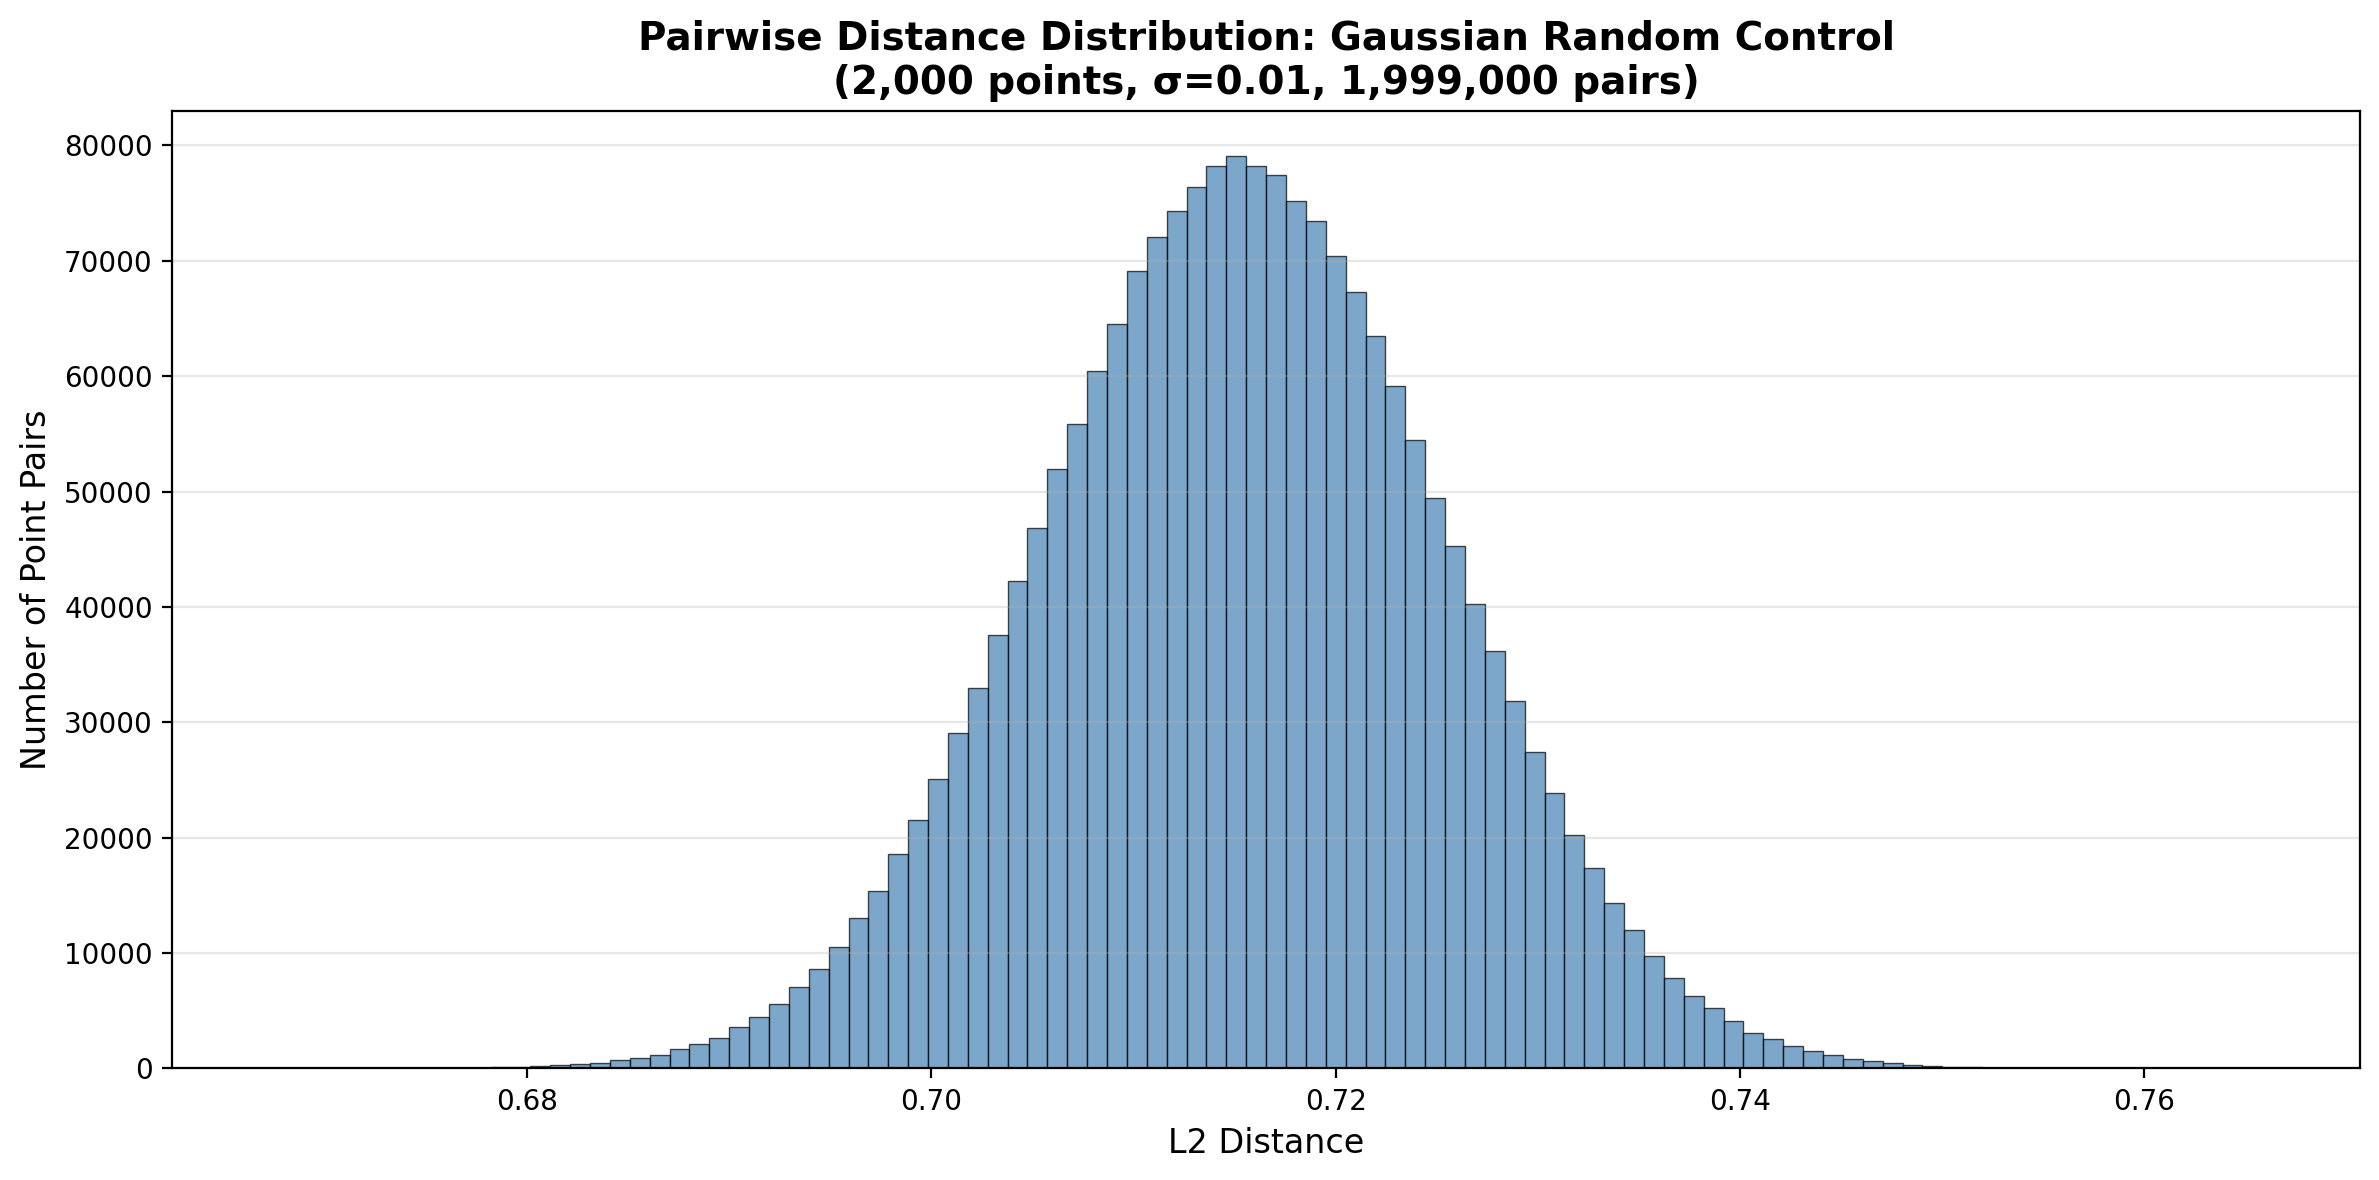

✓ Histogram complete


In [13]:
print(f"\nCreating histogram...\n")

fig, ax = plt.subplots(figsize=FIGSIZE, dpi=DPI)

# Histogram
ax.hist(dists_np, bins=HIST_BINS, color='steelblue', alpha=0.7, 
        edgecolor='black', linewidth=0.5)

# Formatting
ax.set_xlabel('L2 Distance', fontsize=12)
ax.set_ylabel('Number of Point Pairs', fontsize=12)
ax.set_title(f'Pairwise Distance Distribution: Gaussian Random Control\n({NUM_POINTS:,} points, σ={GAUSSIAN_STD}, {len(dists_upper):,} pairs)',
             fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Histogram complete")

## Observations

For Gaussian random points clustered around a centroid, we expect:

- **Smooth, unimodal distribution**: Single peak, no discrete structure
- **Scale determined by σ**: Smaller σ → tighter clustering → smaller typical distances
- **Still Gaussian-like**: Central Limit Theorem applies even for clustered points
- **No exact zeros**: Duplicates have probability ~0
- **No discrete spikes**: No "preferred" distances

Compare to real data (1.4c):
- Real data: 651k pairs at exact distance = 0 (duplicates)
- Real data: Discrete peaks at ~1e-5 scale
- Real data: Hierarchical structure with gaps

**Conclusion**: Even Gaussian clustering cannot explain the discrete structure. The real tokens exhibit **quantized distances** that are incompatible with any continuous random distribution.